In [1]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
from msmbuilder.featurizer import DihedralFeaturizer
from msmbuilder.featurizer import AtomPairsFeaturizer
from msmbuilder.featurizer import ContactFeaturizer
from msmbuilder.cluster import KMedoids
from pyemma.coordinates import tica
from pyemma.coordinates import featurizer
from sklearn import decomposition

import pyemma

pyemma.config.show_progress_bars = False


/Applications/anaconda/envs/py3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Applications/anaconda/envs/py3.6/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
import sys
sys.path.insert(0, '/Users/Bren/Documents/Github/observable-tica/tica-class')

from class_obs_tica import ObservableTicaObject
from class_plots import plot_all
from class_plots import plot_3d
from class_plots import plot_all_obs_cmap

In [3]:
def get_correlation(x_transformed, data, component=0):
    """
    Performs covariance calculations on the (n by n_components+d) matrix [projections|x features]
    Returns a n_components+d vector with the covariances between the x features and the projections onto the tics
    """
    aug = np.column_stack((x_transformed[:, component], np.vstack(data)))

    obj = decomposition.PCA()

    obj.fit(aug)        
    projection_feat_cov = obj.get_covariance().copy()

    variances = np.diagonal(projection_feat_cov)**.5
    projection_feat_corr = obj.get_covariance().copy()
    for i in range(len(projection_feat_corr)):
        for j in range(len(projection_feat_corr[0])):
            projection_feat_corr[i][j] = projection_feat_corr[i][j]/(variances[i]*variances[j])
    return projection_feat_corr[0]
def get_adj_list(topology):
    table, bonds = topology.to_dataframe()
        
    neighbors = {}
    for bond in bonds:
        try:
            neighbors[bond[0]].append(bond[1])
        except:
            neighbors[bond[0]] = [bond[1]]
        try:
            neighbors[bond[1]].append(bond[0])
        except:
            neighbors[bond[1]] = [bond[0]]
    return neighbors
def recurse(quad, rtn, adj_list, visited):
    visited[quad[-1]] = True
    if len(quad) == 4:
        return quad
    if len(quad)< 4:
        neigh = adj_list[quad[-1]]
        for n in neigh:
            visited_copy = visited[:]
            quad_copy = quad[:]
            if visited[n]== False:
                visited[n] == True
                quad_copy.append(n)
                a = (recurse(quad_copy, rtn, adj_list, visited))
                if a is not None:
                    rtn.append(a)

## loading and prepping data for alanine dipeptide

In [4]:
from msmbuilder.example_datasets import AlanineDipeptide
trajs = AlanineDipeptide().get().trajectories

AD_top = trajs[0].topology

AD_neighbors = get_adj_list(AD_top)

alanine_dipeptide already is cached


In [5]:
AD_torsion_quads = []
for atom in range(AD_top.n_atoms):
    rtn = []
    visited = [False]*AD_top.n_atoms
    recurse([atom], rtn, AD_neighbors, visited)
    AD_torsion_quads.extend(rtn)

for i in AD_torsion_quads:
    i.sort()
    
AD_torsion_quads = [tuple(l) for l in AD_torsion_quads]
AD_torsion_quads = set(AD_torsion_quads)

In [6]:
torsion_feat = featurizer(AD_top)
AD_torsion_quads =[list(quad) for quad in AD_torsion_quads]
torsion_feat.add_dihedrals(AD_torsion_quads, cossin=False)
X1 = [torsion_feat.transform(traj) for traj in trajs]

In [7]:
obs_atom_indices = [4,6,8,10,14,16]

# heavy_atom_ind_list = [[j.index for j in i.atoms if j.element.name!="hydrogen"] for i in AD_top.residues]
# heavy_atoms = [atom for residue in heavy_atom_ind_list for atom in residue]

all_pairs = []
for i in range(len(obs_atom_indices)):
    for j in range(i):
        all_pairs.append((obs_atom_indices[i],obs_atom_indices[j]))

In [8]:
interatomic_feat = featurizer(AD_top)
interatomic_feat.add_distances(all_pairs)
Y1 = [interatomic_feat.transform(traj) for traj in trajs]

# Alanine Dipeptide Observable tICA
X1 = all torsions including H
<br>
Y1 = interatomic distances of [C1, N2, Ca2, Cb2, C2, N3]

X dims:  (10, 9999, 41)
Y dims:  (10, 9999, 15)
Fitting data to object pre-whitening
Whitening Data
Estimating Koopman Matrices
largest eigenval:  1.0
Solving Riccati
(24, 24)
Performing SVD
Done.
(99999, 24)
(99999, 24)


Text(0.5,1,'Obervable tICA projection of Ala-Dip| X:ALL TORSIONS, Y: INTERATOMIC DIST')

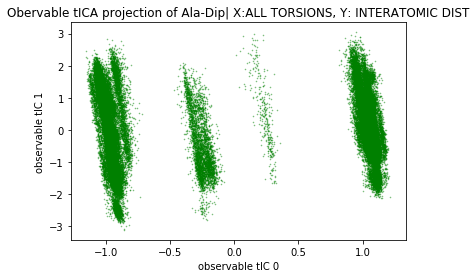

In [9]:
test1 = ObservableTicaObject()
tics1 = test1.fit_transform(X1,Y1)
table, bonds = AD_top.to_dataframe()


plt.scatter(tics1[:,0], tics1[:,1], c='g', s = .3, alpha = .5)
plt.xlabel('observable tIC 0')
plt.ylabel('observable tIC 1')
# plt.xticks([-2, 0, 2])
# plt.yticks([-3, 0, 3])
plt.title('Obervable tICA projection of Ala-Dip| X:ALL TORSIONS, Y: INTERATOMIC DIST')


# Obs tICA projection correlations with X features

component0 correlation vector:
 [  1.00000000e+00   5.47055581e-03   6.69430429e-03  -1.23678269e-01
  -2.65332895e-02  -9.80486168e-01   9.81946788e-03  -3.01637081e-02
  -8.93545666e-03   1.93746998e-03   4.48466977e-03   6.25000716e-02
  -3.66386903e-03  -7.58290865e-03  -1.93367605e-02   9.09903053e-01
  -1.15910738e-03   3.52430275e-01  -8.07361913e-01   3.71892547e-01
  -2.23005405e-04   6.67483584e-03  -1.09156931e-02  -9.67323849e-01
   3.95502652e-04  -1.36545853e-01  -5.46820438e-03  -1.42736625e-01
   4.26242621e-03   3.93233873e-01  -1.18064166e-02  -1.10006996e-01
   1.91997647e-01   3.63622940e-01   1.61575171e-02  -1.97953599e-04
   5.07397690e-03   4.40080382e-01   7.40211743e-02   9.65260322e-01
   9.54887807e-03  -6.00367481e-03]
component1 correlation vector:
 [  1.00000000e+00   6.09304515e-03  -6.89715779e-03  -4.83130274e-03
   1.71732722e-03   1.30004388e-02   1.03285482e-02  -8.88331084e-03
   7.93828752e-02   3.79479360e-03   2.09032125e-03   3.63626035e-02
   

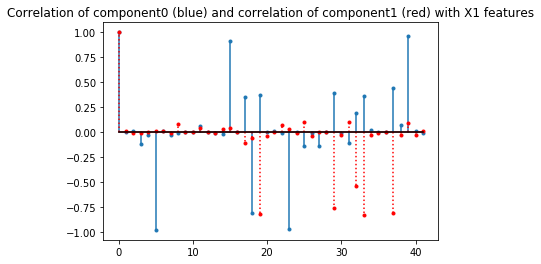

comp0 correlation indices:
 [5, 15, 18, 23, 39]
comp1 correlation indices:
 [19, 29, 32, 33, 37]
comp 0 largest correlation values:
 [-0.98048617  0.90990305 -0.80736191 -0.96732385  0.96526032]
comp 1 largest correlation values:
 [-0.82387343 -0.76180112 -0.54071462 -0.82990355 -0.81268197]
['DIH: ALA 2 CA 8 - ALA 2 CB 10 - ALA 2 C 14 - NME 3 N 16 '
 'DIH: ALA 2 CA 8 - ALA 2 HA 9 - ALA 2 C 14 - NME 3 N 16 '
 'DIH: ALA 2 N 6 - ALA 2 CA 8 - ALA 2 C 14 - NME 3 N 16 '
 'DIH: ALA 2 CA 8 - ALA 2 HA 9 - ALA 2 C 14 - ALA 2 O 15 '
 'DIH: ALA 2 CA 8 - ALA 2 CB 10 - ALA 2 C 14 - ALA 2 O 15 ']
['DIH: ACE 1 C 4 - ALA 2 N 6 - ALA 2 CA 8 - ALA 2 C 14 '
 'DIH: ALA 2 N 6 - ALA 2 H 7 - ALA 2 CA 8 - ALA 2 C 14 '
 'DIH: ACE 1 C 4 - ALA 2 N 6 - ALA 2 CA 8 - ALA 2 CB 10 '
 'DIH: ACE 1 C 4 - ALA 2 N 6 - ALA 2 CA 8 - ALA 2 HA 9 '
 'DIH: ALA 2 N 6 - ALA 2 H 7 - ALA 2 CA 8 - ALA 2 HA 9 ']


In [10]:
X_comp0_corr = test1.get_correlation(X1)
X_comp1_corr = test1.get_correlation(X1, 1)
print('component0 correlation vector:\n', X_comp0_corr)
print('component1 correlation vector:\n', X_comp1_corr)

fig, ax = plt.subplots()

# COR W/ COMP0 IS BLUE
ax.stem(range(len(X_comp0_corr)), X_comp0_corr, markerfmt='.', basefmt = None)

# CORR W/ COMP1 IS RED
ax.stem(range(len(X_comp0_corr)), X_comp1_corr, markerfmt='r.', linefmt ='r:', basefmt='k')
plt.title('Correlation of component0 (blue) and correlation of component1 (red) with X1 features')
plt.show()


big_correl0_ind = [i for i in range(len(X_comp0_corr)) if abs(X_comp0_corr[i])>.5]
big_correl0_ind.remove(0)

big_correl1_ind = [i for i in range(len(X_comp1_corr)) if abs(X_comp1_corr[i])>.5]
big_correl1_ind.remove(0)

print('comp0 correlation indices:\n', big_correl0_ind)
print('comp1 correlation indices:\n', big_correl1_ind)

print('comp 0 largest correlation values:\n', X_comp0_corr[big_correl0_ind])
print('comp 1 largest correlation values:\n', X_comp1_corr[big_correl1_ind])

print(np.array(torsion_feat.describe())[np.subtract(big_correl0_ind,1)]) # -1 because first index is for the projection, not a feature
print(np.array(torsion_feat.describe())[np.subtract(big_correl1_ind,1)]) # -1 because first index is for the projection, not a feature


# Obs tICA projection correlations with Y features

component0 correlation vector:
 [ 1.          0.02536467 -0.01354136  0.05384105  0.35414342 -0.0548455
 -0.01008108 -0.27760085  0.27389283  0.05210673  0.04608111 -0.88921796
 -0.9736854   0.22508686  0.60887635  0.01658911]
component1 correlation vector:
 [  1.00000000e+00   4.26240869e-03   1.00528187e-01   2.22087891e-02
  -7.80206429e-01   2.47609251e-02   1.59000410e-02   8.08705286e-01
  -6.32179270e-02  -4.10614024e-04   1.08107524e-02   3.22254279e-01
  -2.49843396e-02   2.16744051e-02   2.35112854e-02   7.95590188e-03]


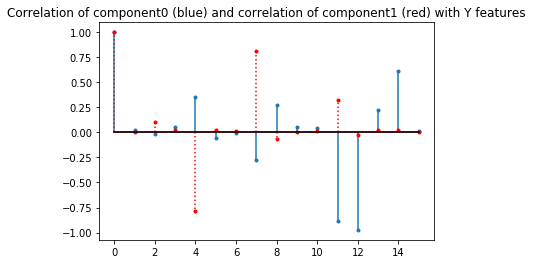

comp0 correlation indices:
 [11, 12, 14]
comp1 correlation indices:
 [4, 7]
comp 0 largest correlation values:
 [-0.88921796 -0.9736854   0.60887635]
comp 1 largest correlation values:
 [-0.78020643  0.80870529]
['DIST: NME 3 N 16 - ACE 1 C 4' 'DIST: NME 3 N 16 - ALA 2 N 6'
 'DIST: NME 3 N 16 - ALA 2 CB 10']
['DIST: ALA 2 CB 10 - ACE 1 C 4' 'DIST: ALA 2 C 14 - ACE 1 C 4']


In [11]:
Y_comp0_corr = test1.get_correlation(Y1)
Y_comp1_corr = test1.get_correlation(Y1, 1)
print('component0 correlation vector:\n', Y_comp0_corr)
print('component1 correlation vector:\n', Y_comp1_corr)

fig, ax = plt.subplots()

# COR W/ COMP0 IS BLUE
ax.stem(range(len(Y_comp0_corr)), Y_comp0_corr, markerfmt='.', basefmt = None)

# CORR W/ COMP1 IS RED
ax.stem(range(len(Y_comp1_corr)), Y_comp1_corr, markerfmt='r.', linefmt ='r:', basefmt='k')
plt.title('Correlation of component0 (blue) and correlation of component1 (red) with Y features')
plt.show()


big_correl0_ind = [i for i in range(len(Y_comp0_corr)) if abs(Y_comp0_corr[i])>.5]
big_correl0_ind.remove(0)

big_correl1_ind = [i for i in range(len(Y_comp1_corr)) if abs(Y_comp1_corr[i])>.5]
big_correl1_ind.remove(0)

print('comp0 correlation indices:\n', big_correl0_ind)
print('comp1 correlation indices:\n', big_correl1_ind)

print('comp 0 largest correlation values:\n', Y_comp0_corr[big_correl0_ind])
print('comp 1 largest correlation values:\n', Y_comp1_corr[big_correl1_ind])

print(np.array(interatomic_feat.describe())[np.subtract(big_correl0_ind,1)]) # -1 because first index is for the projection, not a feature
print(np.array(interatomic_feat.describe())[np.subtract(big_correl1_ind,1)]) # -1 because first index is for the projection, not a feature


# Alanine Dipeptide regular tica:
X1 = all torsions including H

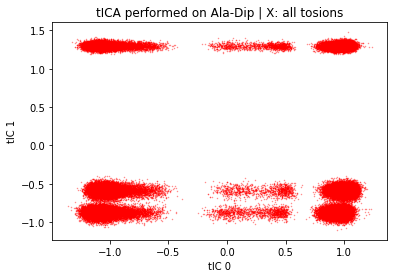

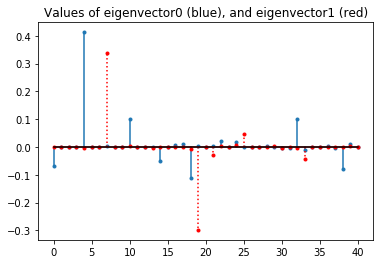

eigenvalue 1:
 0.988851627145
eigenvector 1:
 [ -6.76489715e-02   4.41600941e-04  -8.59229564e-05   1.33521130e-03
   4.12446109e-01   1.68188071e-03   9.91542402e-04   1.84512319e-03
  -1.91541000e-05  -6.13112721e-04   1.02389273e-01   1.74418202e-04
  -5.37621274e-04   8.23362326e-04  -4.90386232e-02   6.92002236e-04
   8.88209569e-03   1.23553204e-02  -1.10169754e-01   4.08388733e-03
   2.26897037e-04   3.08991437e-03   2.10020871e-02  -4.00145544e-05
   1.77848291e-02   1.27979010e-03   1.37683979e-04  -8.58817937e-04
   3.84789562e-03   9.03817826e-04  -2.14570483e-03  -3.21059361e-03
   1.01361060e-01  -9.37979459e-03  -5.88536961e-05   1.37123767e-04
   4.83092934e-03  -3.15527044e-03  -8.08012942e-02   1.23162248e-02
  -6.46309389e-05] 

eigenvalue 2:
 0.980751155591
eigenvector 2:
 [  1.29879768e-04   2.07810497e-04   4.17080745e-04  -1.20200349e-03
  -3.68355540e-03  -3.35282891e-05   1.97203876e-04   3.38868234e-01
  -1.49923086e-04  -1.21347501e-04   2.52615287e-03  -6.253

In [12]:
obj_AD = tica(X1, lag = 1, dim = 2)
plt.show()
data = np.array(obj_AD.get_output())
data = np.vstack(data)
plt.scatter(data[:,0], data[:,1], s = .2, alpha = .5, c='r')
plt.xlabel('tIC 0')
plt.ylabel('tIC 1')
# plt.xticks([-2, 0, 2])
# plt.yticks([-3, 0, 3])
plt.title('tICA performed on Ala-Dip | X: all tosions')
plt.show()


fig, ax = plt.subplots()
# FIRST TIC IS BLUE
ax.stem(range(len(obj_AD.eigenvectors[:,0])), obj_AD.eigenvectors[:,0], markerfmt='.', basefmt = None)

# SECOND TIC IS RED
ax.stem(range(len(obj_AD.eigenvectors[:,1])), obj_AD.eigenvectors[:,1], markerfmt='r.', linefmt ='r:', basefmt='k')
plt.title('Values of eigenvector0 (blue), and eigenvector1 (red)')
plt.show()

print('eigenvalue 1:\n', obj_AD.eigenvalues[0])
print('eigenvector 1:\n', obj_AD.eigenvectors[:,0], '\n')
print('eigenvalue 2:\n', obj_AD.eigenvalues[1])
print('eigenvector 2:\n', obj_AD.eigenvectors[:,1], '\n')

comp0_large_svals = [i for i in range(len(obj_AD.eigenvectors[:,0])) if abs(obj_AD.eigenvectors[:,0][i])>.1]
comp1_large_svals = [i for i in range(len(obj_AD.eigenvectors[:,0])) if abs(obj_AD.eigenvectors[:,1][i])>.1]

print('\neigenvector1 indices with values>0.1:\n', comp0_large_svals)
print('eigenvector indices with values>0.1:\n', comp1_large_svals)



print('\ntorsion angles corresponding to largest eigenvector(0) values:\n', np.array(torsion_feat.describe())[comp0_large_svals])
print('torsion angles corresponding to largest eigenvector(1) values:\n', np.array(torsion_feat.describe())[comp1_large_svals])

print('\nall X featurs:\n', torsion_feat.describe())


# print('torsion angle corresponding to largest reg component(0) value:\n', list(AD_torsion_quads)[np.argmax(abs(obj_AD.eigenvectors[:,0]))])
# print('torsion angle corresponding to largest reg component(1) value:\n', list(AD_torsion_quads)[np.argmax(abs(obj_AD.eigenvectors[:,1]))])
# print(obj_AD.eigenvectors[:,1][19], list(AD_torsion_quads[19]))

print(table)

# Regular tICA projection correlation with X features

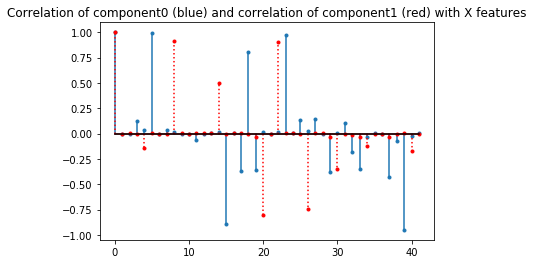

comp0 correlation indices:
 [5, 15, 18, 23, 39]
comp1 correlation indices:
 [8, 20, 22, 26]
comp 0 largest correlation values (>0.5):
 [ 0.99434634 -0.89240012  0.8064991   0.96880379 -0.95147522]
comp 1 largest correlation values (>0.5):
 [ 0.91779732 -0.80470272  0.90435739 -0.74187653]
['DIH: ALA 2 CA 8 - ALA 2 CB 10 - ALA 2 C 14 - NME 3 N 16 '
 'DIH: ALA 2 CA 8 - ALA 2 HA 9 - ALA 2 C 14 - NME 3 N 16 '
 'DIH: ALA 2 N 6 - ALA 2 CA 8 - ALA 2 C 14 - NME 3 N 16 '
 'DIH: ALA 2 CA 8 - ALA 2 HA 9 - ALA 2 C 14 - ALA 2 O 15 '
 'DIH: ALA 2 CA 8 - ALA 2 CB 10 - ALA 2 C 14 - ALA 2 O 15 ']
['DIH: ALA 2 CA 8 - ALA 2 HA 9 - ALA 2 CB 10 - ALA 2 HB2 12 '
 'DIH: ALA 2 CA 8 - ALA 2 HA 9 - ALA 2 CB 10 - ALA 2 HB3 13 '
 'DIH: ALA 2 CA 8 - ALA 2 CB 10 - ALA 2 HB1 11 - ALA 2 C 14 '
 'DIH: ALA 2 CA 8 - ALA 2 CB 10 - ALA 2 HB2 12 - ALA 2 C 14 ']


In [13]:
X_tic0_corr = get_correlation(data, X1)
X_tic1_corr = get_correlation(data, X1,1)

fig, ax = plt.subplots()

# COR W/ COMP0 IS BLUE
ax.stem(range(len(X_tic0_corr)), X_tic0_corr, markerfmt='.', basefmt = None)

# CORR W/ COMP1 IS RED
ax.stem(range(len(X_tic1_corr)), X_tic1_corr, markerfmt='r.', linefmt ='r:', basefmt='k')
plt.title('Correlation of component0 (blue) and correlation of component1 (red) with X features')
plt.show()


big_correl0_ind = [i for i in range(len(X_tic0_corr)) if abs(X_tic0_corr[i])>.5]
big_correl0_ind.remove(0)

big_correl1_ind = [i for i in range(len(X_tic1_corr)) if abs(X_tic1_corr[i])>.5]
big_correl1_ind.remove(0)

print('comp0 correlation indices:\n', big_correl0_ind)
print('comp1 correlation indices:\n', big_correl1_ind)

print('comp 0 largest correlation values (>0.5):\n', X_tic0_corr[big_correl0_ind])
print('comp 1 largest correlation values (>0.5):\n', X_tic1_corr[big_correl1_ind])

print(np.array(torsion_feat.describe())[np.subtract(big_correl0_ind,1)]) # -1 because first index is for the projection, not a feature
print(np.array(torsion_feat.describe())[np.subtract(big_correl1_ind,1)]) # -1 because first index is for the projection, not a feature


# Regular tICA projection correlation with Y features

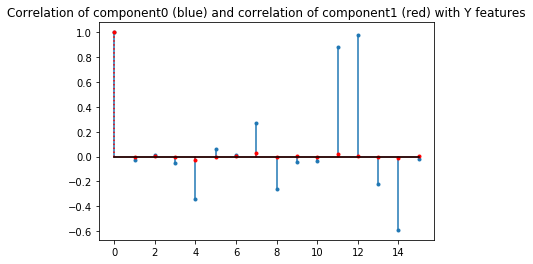

comp0 correlation indices:
 [11, 12, 14]
comp1 correlation indices:
 []
comp 0 largest correlation values(>0.5):
 [ 0.88021263  0.97540133 -0.59063658]
comp 1 largest correlation values(>0.5):
 []
['DIST: NME 3 N 16 - ACE 1 C 4' 'DIST: NME 3 N 16 - ALA 2 N 6'
 'DIST: NME 3 N 16 - ALA 2 CB 10']


In [14]:
Y_tic0_corr = get_correlation(data, Y1)
Y_tic1_corr = get_correlation(data, Y1,1)

fig, ax = plt.subplots()

# COR W/ COMP0 IS BLUE
ax.stem(range(len(Y_tic0_corr)), Y_tic0_corr, markerfmt='.', basefmt = None)

# CORR W/ COMP1 IS RED
ax.stem(range(len(Y_tic1_corr)), Y_tic1_corr, markerfmt='r.', linefmt ='r:', basefmt='k')
plt.title('Correlation of component0 (blue) and correlation of component1 (red) with Y features')
plt.show()


big_correl0_ind = [i for i in range(len(Y_tic0_corr)) if abs(Y_tic0_corr[i])>.5]
big_correl0_ind.remove(0)

big_correl1_ind = [i for i in range(len(Y_tic1_corr)) if abs(Y_tic1_corr[i])>.5]
big_correl1_ind.remove(0)

print('comp0 correlation indices:\n', big_correl0_ind)
print('comp1 correlation indices:\n', big_correl1_ind)

print('comp 0 largest correlation values(>0.5):\n', Y_tic0_corr[big_correl0_ind])
print('comp 1 largest correlation values(>0.5):\n', Y_tic1_corr[big_correl1_ind])

if big_correl0_ind:
    print(np.array(interatomic_feat.describe())[np.subtract(big_correl0_ind,1)]) # -1 because first index is for the projection, not a feature
if big_correl1_ind:
    print(np.array(interatomic_feat.describe())[np.subtract(big_correl1_ind,1)]) # -1 because first index is for the projection, not a feature


# NO ANALYSIS BELOW

## loading and prepping met-e data

In [15]:
# from msmbuilder.example_datasets import MetEnkephalin
# print(type(MetEnkephalin))
# trajs = MetEnkephalin().get().trajectories
# ME_top = trajs[0].topology


In [16]:
# ME_torsion_quads = []

# table, bonds = ME_top.to_dataframe()

# bond_set = [set(bond) for bond in bonds]
# n_tor = []
# for bond1 in bonds:
#     b1 = set(bond1)
#     for bond2 in bonds:
#         b2 = set(bond2)
#         if len(b1 | b2)==4:
#             for i in b1:
#                 for j in b2:
#                     a = {i,j}
#                     if a in bond_set:
#                         n_tor.append(list(a|b1|b2))

# for quad in n_tor:
#     quad.sort()
# # print(n_tor)
# a = [tuple(l) for l in n_tor]
# ME_torsion_quads = set(a)

# ME_torsion_feat = featurizer(ME_top)
# ME_torsion_quads =[list(quad) for quad in ME_torsion_quads]
# ME_torsion_feat.add_dihedrals(ME_torsion_quads,cossin=True)

# X2 = [ME_torsion_feat.transform(traj) for traj in trajs]

# ME_dihedral_feat = featurizer(ME_top)
# ME_dihedral_feat.add_backbone_torsions(cossin=True)
# Y2 = [ME_dihedral_feat.transform(traj) for traj in trajs]


# Met-Enkephalin Obs tICA
X2 = All torsions including H
<br>
Y2 = Backbone torsions

In [17]:
# test2 = ObservableTicaObject()
# tics2 = test2.fit_transform(X2,Y2)
# plt.scatter(tics2[:,0], tics2[:,1], c='g', s = .3, alpha = .5)
# plt.xlabel('observable tIC 0')
# plt.ylabel('observable tIC 1')
# # plt.xticks([-2, 0, 2])
# # plt.yticks([-3, 0, 3])
# plt.title('Obervable tICA projection of Met-Enkephalin')

# m0 = test2.get_correlation(Y2)
# m1 = test2.get_correlation(Y2,1)
# print('comp0 corr vector:\n', m0)
# print('comp1 corr vector:\n', m1)

# fig, ax = plt.subplots()

# # COR W/ COMP0 IS BLUE
# ax.stem(range(len(m0)), m0, markerfmt='.', basefmt = None)

# # CORR W/ COMP1 IS RED
# ax.stem(range(len(m1)), m1, markerfmt='r.', linefmt ='r:', basefmt='k')
# plt.title('Correlation of component0 (blue) and correlation of component1 (red) with X features')
# plt.show()


# big_correl0_ind = [i for i in range(len(m0)) if abs(m0[i])>.5]
# big_correl0_ind.remove(0)

# big_correl1_ind = [i for i in range(len(m1)) if abs(m1[i])>.5]
# big_correl1_ind.remove(0)

# print('comp0 correlation indices:\n', big_correl0_ind)
# print('comp1 correlation indices:\n', big_correl1_ind)

# print('comp 0 largest correlation values:\n', m0[big_correl0_ind])
# print('comp 1 largest correlation values:\n', m1[big_correl1_ind])

# print('X features corresponding to largest correlations with X projected onto comp0:\n', np.array(ME_torsion_feat.describe())[np.subtract(big_correl0_ind,1)]) # -1 because first index is for the projection, not a feature
# print('X features corresponding to largest correlations with X projected onto comp1:\n', np.array(ME_torsion_feat.describe())[np.subtract(big_correl1_ind,1)]) # -1 because first index is for the projection, not a feature


# print(table)

# Met-Enkephalin regular tica
X2 = all torsions including H

In [18]:
# print(len(X2), X2[0].shape)

# obj_ME = tica(X2, lag = 1, dim = 2)
# plt.show()
# data = np.array(obj_ME.get_output())
# data = np.vstack(data)
# plt.scatter(data[:,0], data[:,1], s = .2, alpha = .5, c='r')
# plt.xlabel('tIC 0')
# plt.ylabel('tIC 1')
# # plt.xticks([-2, 0, 2])
# # plt.yticks([-3, 0, 3])
# plt.title('tICA performed on Alanine Dipeptide')
# plt.show()



# # fig, ax = plt.subplots()
# # # FIRST TIC IS BLUE
# # ax.stem(range(len(obj_ME.eigenvectors[:,0])), obj_ME.eigenvectors[:,0], markerfmt='.', basefmt = None)

# # # SECOND TIC IS RED
# # ax.stem(range(len(obj_ME.eigenvectors[:,1])), obj_ME.eigenvectors[:,1], markerfmt='r.', linefmt ='r:', basefmt='k')
# # plt.title('Values of component0 (blue), and component1 (red)')
# # plt.show()

# # print(np.amax(obj_ME.feature_TIC_correlation))

# # print('eigenvalue 1:\n', obj_ME.eigenvalues[0])
# # print('eigenvector 1:\n', obj_ME.eigenvectors[:,0], '\n')
# # print('eigenvalue 2:\n', obj_ME.eigenvalues[1])
# # print('eigenvector 2:\n', obj_ME.eigenvectors[:,1], '\n')


# # print('torsion angle corresponding to largest reg component(0) value:\n', list(ME_torsion_quads)[np.argmax(abs(obj_AD.eigenvectors[:,0]))])
# # print('torsion angle corresponding to largest reg component(1) value:\n', list(ME_torsion_quads)[np.argmax(abs(obj_AD.eigenvectors[:,1]))])


# # # print('all flexible torsions in AD:\n', ME_torsion_quads, '\n')
# # table, bonds = ME_top.to_dataframe()

# print(table)